In [4]:
import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
import ast as ast
import numpy as np
from typing import *

from task_2_helpers import *
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import Sequential

import nltk
from nltk.tokenize import word_tokenize

import datasets
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from textblob import TextBlob
from collections import defaultdict

import matplotlib.pyplot as plt

# from task2_business_KNN import classify_Kmeans


/home/kidou/Documents/UNIGE/ml_reinforcement/Projects/customer/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-19 16:34:18.233745: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 16:34:18.840082: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 16:34:18.843518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 16:34:20.104394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

### Data Read

In [3]:
# df_business = pd.read_parquet('data/ATML2024_businesses.parquet')
df_business = pd.read_csv('data/ATML2024_businesses.csv', header=0)
print(df_business.shape)
# df_Train_reviews = pd.read_parquet('data/ATML2024_reviews_train.parquet')
df_Train_reviews = pd.read_csv('data/ATML2024_reviews_train.csv', header=0)

# # df_users = pd.read_parquet('data/ATML2024_users.parquet')
# df_users = pd.read_csv('data/ATML2024_users.csv', header=0, nrows=100)

(138210, 11)


In [4]:
df_business.postal_code.isna().value_counts()

postal_code
False    138145
True         65
Name: count, dtype: int64

In [5]:
zipCodes = dict(df_business.postal_code.value_counts())

val_count = 0
for z in zipCodes.keys():
    try:
        zcode = int(z)
        if zcode >= 19019 and  zcode <= 19255: ### Philadelphia zip codes
            val_count += zipCodes[str(z)]
    except:
        continue

print(val_count)

19707


In [6]:
bussiness_city = ['Phila','Philadelphia', 'Philadelphia', 'Philadelphia (Northeast Philly)', 'Philadelphia PA', 'Philadelphila', 'Philadephia', 'Philiadelphia', 
                  'Philiidelphia', 'Philly', 'Southwest Philadelphia', 'West Philadelphia', 'philadelphia', 'PHILA', 'PHILADELPHIA']
print(df_business[df_business['city'].isin(bussiness_city)].shape)


(13617, 11)


### Cleanup business data columns

In [7]:
df_business['postal_code_int'] = pd.to_numeric(df_business['postal_code'], errors='coerce', downcast='integer')
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,attributes,categories,hours,postal_code_int
0,wPYArZCy3AETdTjB-x3fpm,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",63123.0
1,QQNIWVsnAT_iKiKriWrFUt,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",85711.0
2,wm9eoqjytVbC7dQcM4WSTM,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",19107.0
3,AfVDXGIKBUE0EdTw_6cMWm,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",18054.0
4,QjvanH64QUduo6E-8F33FC,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",37015.0


In [8]:
# Convert dictionary columns to the correct types @@@@ Run only once
df_business_ph = df_business.loc[ (df_business['postal_code_int'] >= 19019) & (df_business['postal_code_int'] <= 19255) ].copy()
print(df_business_ph.shape)
df_business_ph['attributes'] = df_business_ph['attributes'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())
print(df_business_ph.shape)
df_business_ph['hours'] = df_business_ph['hours'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())
print(df_business_ph.shape)

# df_business['weekend'] = df_business['hours'].apply(lambda x: extract_weekend_value(x))
df_business_ph['hours_list'] = df_business_ph['hours'].apply(lambda x: extract_hours_value(x))

print(df_business_ph.shape)

(19707, 12)
(19707, 12)
(19707, 12)
(19707, 13)


In [9]:
df_business_ph['attributes_list'] = df_business_ph['attributes'].apply(lambda x: sorted(extract_attributes_value(x)))
df_business_ph['categories_list'] = df_business_ph['categories'].apply(lambda x: sorted(map(lambda a: a.strip().lower(), x.split(',')) ) if isinstance(x, str) else [x])

### Join Business Data With Ratings Data and Conduct Exploratory Data Analysis (EDA)

In [10]:
df_business_data = df_business_ph[['business_id', 'postal_code_int', 'attributes_list', 'hours_list', 'categories_list']]
df_ratings_data = df_Train_reviews[['business_id', 'rating', 'useful', 'funny', 'cool', 'text']]

df_data = pd.merge(df_business_data, df_ratings_data, left_on= 'business_id', right_on='business_id')
print(df_data.shape)
df_data.head()

(176549, 10)


,business_id,postal_code_int,attributes_list,hours_list,categories_list,rating,useful,funny,cool,text
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",4,1,0,2,So I don't know how the other review was doubl...
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,0,0,0,I love this place.. I love their chunky fried...
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,0,0,1,I ordered so many cake from here for our famil...
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",4,0,0,0,Ordered a birthday cake here for the first tim...
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,1,0,0,This is my favorite bakery in Chinatown! It's ...


In [1]:
df_data.to_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet')

NameError: name 'df_data' is not defined

### Explanatory Data Analysis

In [5]:
df_data = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data.shape)

df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]
df_data_res.shape


(176549, 12)


(123414, 12)

In [6]:
# all_uniq_cat = set(np.concatenate(df_data.categories_list.values).ravel()) #df_data.categories_list.values.flatten()
# all_uniq_attr = set(np.concatenate(df_data.attributes_list.values).ravel()) #df_data.categories_list.values.flatten()

#### 2.0 Find out which one of the categories are related to restaurant services

Before deal with the reviews and treds in them, we need to identify which one of the businesses are actually in the restaurant and related area.

In [7]:
business_cat = np.concatenate(df_data.categories_list.values).ravel()
c = Counter(business_cat)

print(f'Total number of distinct categories of business: {len(c)}')

print(f'The most frequest categories : {c.most_common(10)}')

df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]
                                                                
print(df_data_res.shape)                                                    

Total number of distinct categories of business: 1081
The most frequest categories : [('restaurants', 123410), ('food', 47310), ('nightlife', 40206), ('bars', 38164), ('american (new)', 26829), ('breakfast & brunch', 22358), ('american (traditional)', 21800), ('sandwiches', 19789), ('italian', 15313), ('coffee & tea', 14008)]
(123414, 12)


### 2.2 What is the food trend of Philadelphia

In [8]:
# rating_1_cat = set(np.concatenate(df_data[df_data.rating == 1].categories_list.values).ravel())
# rating_2_cat = set(np.concatenate(df_data[df_data.rating == 2].categories_list.values).ravel())
# rating_3_cat = set(np.concatenate(df_data[df_data.rating == 3].categories_list.values).ravel())
# rating_4_cat = set(np.concatenate(df_data[df_data.rating == 4].categories_list.values).ravel())
# rating_5_cat = set(np.concatenate(df_data[df_data.rating == 5].categories_list.values).ravel())

#### 2.3 Transformer (Kyril)

In [7]:
sent_pipe = pipeline("sentiment-analysis", # or "text-classification"
                     model="distilbert-base-uncased-finetuned-sst-2-english")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [9]:
# Use tokenize function to ignore too long 
# Define stopwords and punctuation

#stop_words = set(stopwords.words('english'))
#punctuation = set(string.punctuation)

def clean_tokens(text : str) -> List:
    
    # Tokenize the text
    token = word_tokenize(text.lower())
    
    # Remove unwanted punctuation and stop words
    # if extra_clean == True:
    #    tokens = [word for word in tokens if (word not in punctuation and word not in stop_words)]

    return token

In [10]:
df_data_res['text_tokens']  = df_data_res['text'].apply(clean_tokens)
df_data_res['tokens_count'] = df_data_res['text_tokens'].apply(len)

/tmp/ipykernel_14350/792970574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_res['text_tokens']  = df_data_res['text'].apply(clean_tokens)
/tmp/ipykernel_14350/792970574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_res['tokens_count'] = df_data_res['text_tokens'].apply(len)


In [2]:
df_data_res.to_parquet('data/ATML2024_Task2_PhiliResRatings.parquet')

NameError: name 'df_data_res' is not defined

Milestone 

In [9]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliResRatings.parquet', engine='pyarrow')
print(df_data_res.shape)

(123414, 12)


In [13]:
df_res_short = df_data_res[df_data_res['tokens_count'] < 256]

It is possible to reduce the size of the too big reviews using a text2text pretrained model. 
Exemple bellow uses pytorch

In [14]:
"""Generate smaller text from bigger text using transformer tokenizer"""

try: 
    import torch 
    
    model_name = "allenai/led-large-16384-arxiv"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    
    pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)

    # apply below function to all reviews 
    def generate_smaller_text(text : str, length : int = 64) -> str:
        generated_text = pipe(
            text, 
            truncation=True, 
            max_length=length, 
            no_repeat_ngram_size=5, 
            num_beams=3, 
            early_stopping=True
        )

except ImportError as e:
    print("Error : {}".format(e))
    

Error : No module named 'torch'


In [18]:
review_list = df_res_short['text'].to_list()
# sentiments = sent_pipe(review_list)
df_sentiments = pd.DataFrame(sentiments)
df_sentiments.rename(columns={'label':'sentiment', 'score':'sent_score'}, inplace=True)

#### 2.4 Sentiment Analysis

In [10]:
# Function to calculate sentiment score from pretrained models
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [11]:
# Calculate sentiment for each review
df_data_res['sentiment'] = df_data_res['text'].apply(get_sentiment)

In [97]:
# Initialize dictionaries to store ratings and sentiments for each attribute
attribute_ratings = defaultdict(list)
attribute_sentiments = defaultdict(list)

# Populate the dictionaries
for index, row in df_data_res.iterrows():
    for attribute in row['attributes_list']:
        attribute_ratings[attribute].append(row['rating'])
        attribute_sentiments[attribute].append(row['sentiment'])

# Remove the last quantile of sentiments and 
n_cut = 10
attribute_ratings_sub = dict(sorted(attribute_ratings.items(), key=lambda x:len(x[1]), reverse=True)[:n_cut])
attribute_sentiments_sub = dict(sorted(attribute_sentiments.items(), key=lambda x:len(x[1]), reverse=True)[:n_cut])

# Calculate the mean rating and mean sentiment for each attribute
attribute_mean_ratings_sub = {attr: sum(ratings) / len(ratings) for attr, ratings in attribute_ratings_sub.items()}
attribute_mean_sentiments_sub = {attr: sum(sentiments) / len(sentiments) for attr, sentiments in attribute_sentiments_sub.items()}

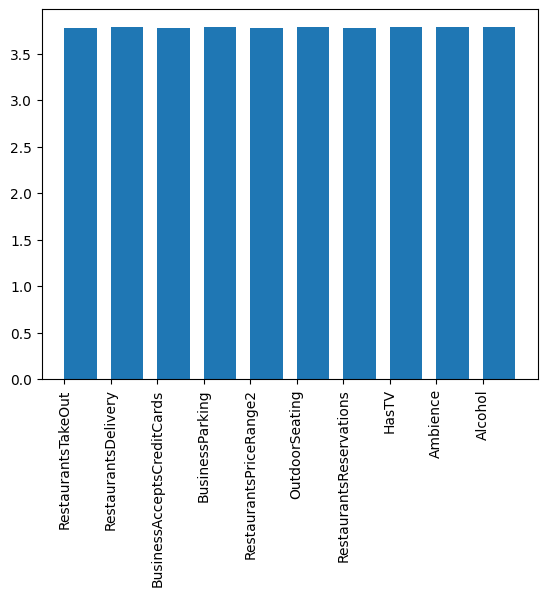

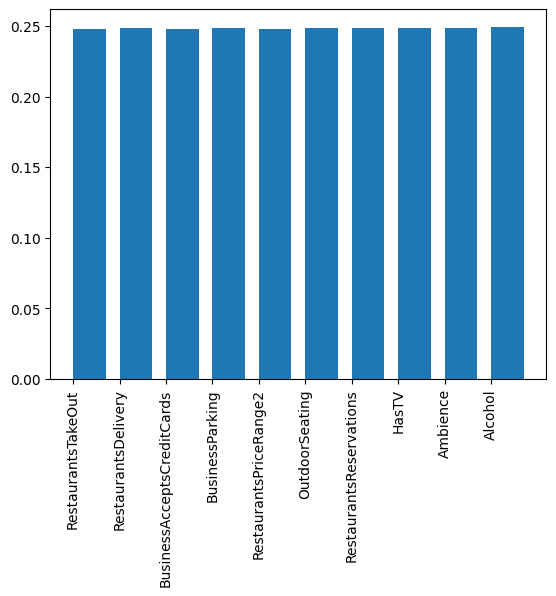

In [99]:
# Box plot 
plt.bar(range(1, len(attribute_mean_ratings_sub) + 1), list(attribute_mean_ratings_sub.values()),  align='edge', width=0.7)
plt.xticks(range(1, len(attribute_mean_ratings_sub) + 1), attribute_mean_ratings_sub.keys(),rotation=90)
plt.show()

plt.bar(range(1, len(attribute_mean_sentiments_sub ) + 1), list(attribute_mean_sentiments_sub.values()),  align='edge', width=0.7)
plt.xticks(range(1, len(attribute_mean_sentiments_sub ) + 1), attribute_mean_sentiments_sub .keys(),rotation=90)
plt.show()

#### 2.5 Aspect based sentiment Analysis 